# Design 2-color mCherry smFISH

by Pu Zheng


In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

3327355


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/ChromAn') # parent folder of ChromAn
import src

## Master folder
folder storing all the libraries

In [3]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [4]:
reference_folder = r'/lab/solexa_weissman/puzheng/References/'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [5]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'smFISH', 'mCherry')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry/designed_probes_idt_oPool.xlsx


In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [7]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
cdna = qc.check_and_standardize_transcriptome(cdna, remove_non_standard_columns=True)

#ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ], ignore_index=True)
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version



# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
CPU times: user 1.89 s, sys: 328 ms, total: 2.22 s
Wall time: 2.21 s


In [10]:
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116907,ENSMUST00000215557.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111578.2,Gm18166
116908,ENSMUST00000215627.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111460.2,None
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713


In [11]:
# Let's have a look at the transcripts of the FLNA gene
transcriptome[transcriptome['gene_short_name'] == 'Cebpa'].sort_values('FPKM', ascending=False)

,transcript_id,sequence,FPKM,gene_id,gene_short_name
91805,ENSMUST00000205391.2,ATTCGCGACCCGAAGCTGCGCGGGCGCGAGCCAGTTGGGGCACTGG...,1,ENSMUSG00000034957.11,Cebpa
91806,ENSMUST00000042985.11,CGAAGCTGCGCGGGCGCGAGCCAGTTGGGGCACTGGGTGGGCGGCG...,1,ENSMUSG00000034957.11,Cebpa


## Add mCherry into transcriptome

In [12]:
# sequence directly copied from the vector
gene1_row = pd.Series(
    {'transcript_id':'artificialTranscript_mCherry_t1',
     'sequence': 'ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGCGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAATGAA',
     'FPKM': 1,
     'gene_id':'artificialTranscript_mCherry',
     'gene_short_name': 'mCherry',
    }
)

In [14]:
transcriptome = pd.concat([transcriptome, gene1_row.to_frame().T], ignore_index=True)
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116908,ENSMUST00000215627.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111460.2,None
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713
116911,ENSMUST00000208550.2,ATGGATAAAAGAGAATCACTCTATTGTGTCTGAGTTTGTGTTCTTG...,1,ENSMUSG00000109522.2,None


## Select genes

In [15]:
sel_genes = ['mCherry']

### based on genes, select 2-color readouts

In [16]:
readout_df = fio.load_fasta_into_df(readout_fasta_file)
readout_names = list(readout_df['id'])

start_bit = 22

bit_names = readout_names[start_bit:start_bit+2*len(sel_genes)]
readout_seqs = readout_df['sequence'][start_bit:start_bit+2*len(sel_genes)]
print(bit_names)

['Bit-23-RS0763', 'Bit-24-RS0793']


### design 2-color barcode table

In [17]:
barcodes = []
for _i, _name in enumerate(sel_genes):
    _base_str = np.zeros(2*len(sel_genes), dtype=np.int32)
    _base_str[2*_i:2*_i+2] = 1
    barcodes.append(''.join(_base_str.astype(str)))

### combine

In [18]:
barcode_table = pd.DataFrame({'name':sel_genes, 
                              #'id':['ENSMUSG00000061527.8', 'ENSMUSG00000000731.16'], 
                              #'id':['ENSMUST00000023709.7', 'ENSMUST00000145975.8'], 
                              'barcode_str':barcodes})
barcode_table

,name,barcode_str
0,mCherry,11


## Initialize probe dict

In [19]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(sel_genes, transcriptome, 
                                 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 1 transcripts for 1 target genes.
Gene	Transcript	N_probes
mCherry
	artificialTranscript_mCherry_t1	686


## Calculate and filter by probe GC

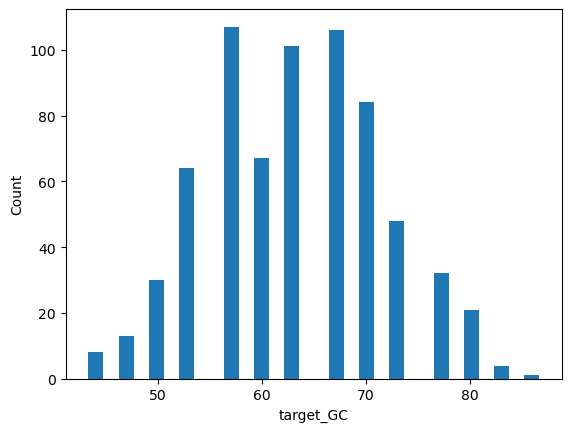

In [20]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

mCherry
	artificialTranscript_mCherry_t1: 496 / 686 probes passed the filter 40 < target_GC <  70.


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


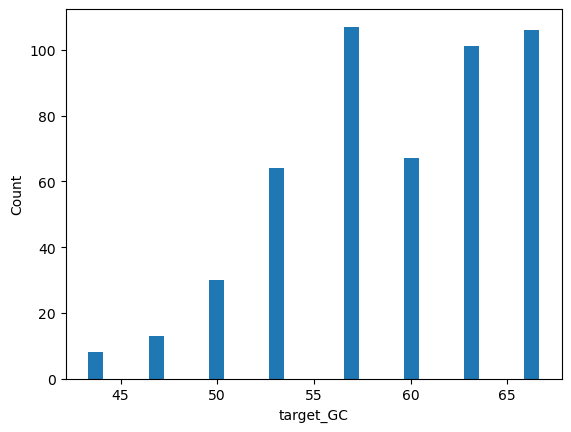

In [21]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

## Calculate and filter by probe Tm

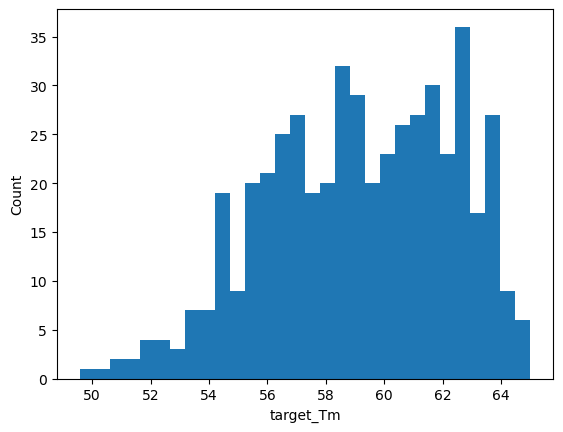

In [22]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

mCherry
	artificialTranscript_mCherry_t1: 493 / 496 probes passed the filter 50 < target_Tm <  65.


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


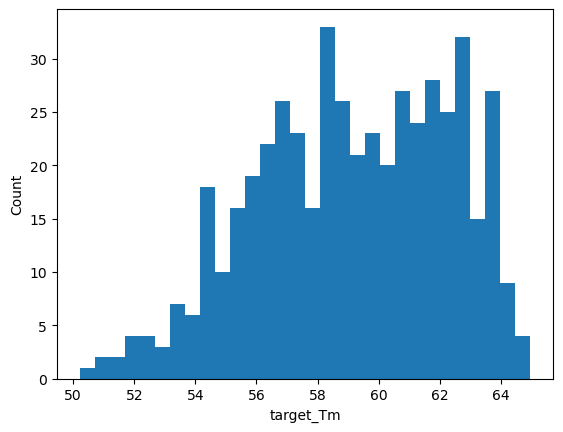

In [23]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

## Calculate off-targets

### Generate CountTable

In [24]:
# Initialize the off-target counting tables
overwrite_ottable = True
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [25]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_genes, 'gene_short_name', 17)

Generate OTTable for gene mCherry.
Construct a OTTable using 1/1 transcripts with FPKM > 0.


In [26]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116913/116913 transcripts with FPKM > 0.
Processed 1000/116913 sequences.
Processed 2000/116913 sequences.
Processed 3000/116913 sequences.
Processed 4000/116913 sequences.
Processed 5000/116913 sequences.
Processed 6000/116913 sequences.
Processed 7000/116913 sequences.
Processed 8000/116913 sequences.
Processed 9000/116913 sequences.
Processed 10000/116913 sequences.
Processed 11000/116913 sequences.
Processed 12000/116913 sequences.
Processed 13000/116913 sequences.
Processed 14000/116913 sequences.
Processed 15000/116913 sequences.
Processed 16000/116913 sequences.
Processed 17000/116913 sequences.
Processed 18000/116913 sequences.
Processed 19000/116913 sequences.
Processed 20000/116913 sequences.
Processed 21000/116913 sequences.
Processed 22000/116913 sequences.
Processed 23000/116913 sequences.
Processed 24000/116913 sequences.
Processed 25000/116913 sequences.
Processed 26000/116913 sequences.
Processed 27000/116913 sequences.
Processed 28000/116913 s

### Off-targets to rRNA/tRNAs

In [27]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/1 genes.
mCherry
	artificialTranscript_mCherry_t1: 493 / 493 probes passed the filter -inf < target_OT_rtRNA <  0.5.


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


### Off-targets to transcriptome

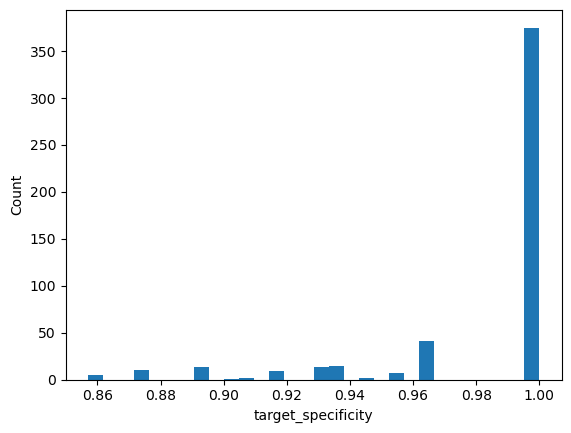

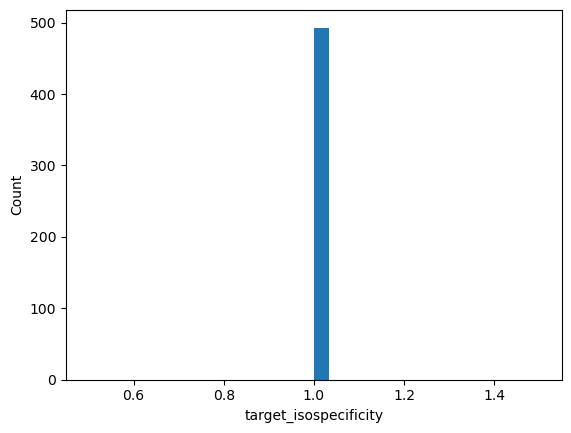

In [28]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [29]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

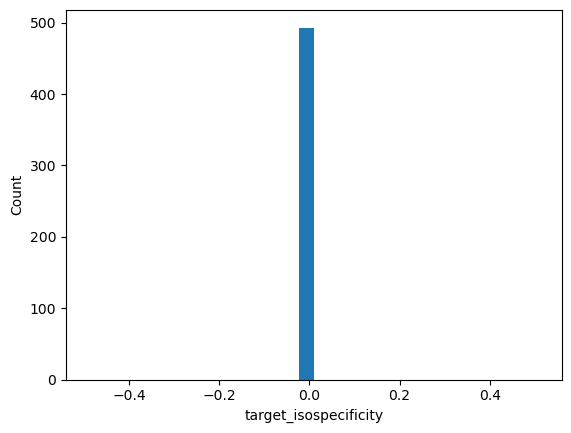

In [30]:
plot.plot_hist(probe_dict, 'target_isospecificity')

mCherry
	artificialTranscript_mCherry_t1: 375 / 493 probes passed the filter 0.99 < target_specificity <  inf.


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


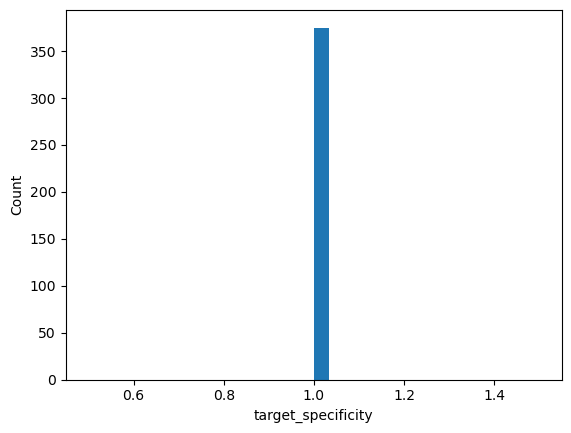

In [31]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

mCherry
	artificialTranscript_mCherry_t1: 375 / 375 probes passed the filter 0.0 < target_isospecificity <  0.66.


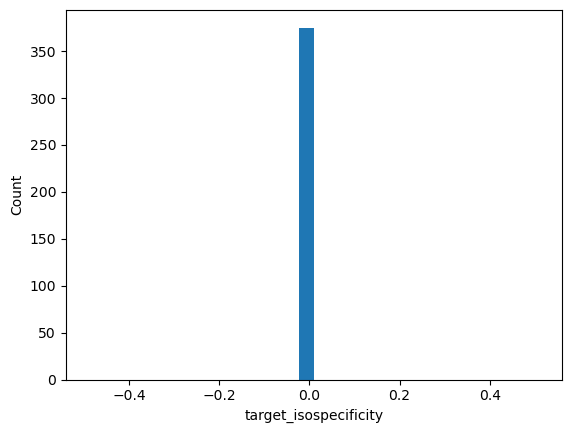

In [32]:
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', 
                                    lower_bound=0., upper_bound=0.66)
plot.plot_hist(probe_dict, 'target_isospecificity')

## Select the transcript with the most probes

In [33]:
select_transcripts = True
if select_transcripts:
    # Manual selection
    #probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['ENSMUST00000003100.10', ])
    
    # Select the transcript with most probes passed QC:
    probe_dict = p_d.select_transcripts_by_num_probes(probe_dict)
    p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
mCherry
	artificialTranscript_mCherry_t1	375


# Add readouts

In [36]:
# Load readouts
readout_seqs = readout_df[start_bit:start_bit+2*len(sel_genes)]
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/MERFISH_probe_design/probe_design/readout_sequences.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readout_seqs['on-bit'] = pd.Series(on_bits, index=readout_seqs.index)


,id,description,sequence,on-bit
22,Bit-23-RS0763,Bit-23-RS0763,ATAAATCATTCCCACTACCC,0
23,Bit-24-RS0793,Bit-24-RS0793,ACCCAACACTCATAACATCC,1


In [37]:
# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readout_per_probe = 2
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 
                                     num_readout_per_probe, 
                                     spacer='', gene_id_key='name', 
                                     each_probe_1_on_bit=True)

Added readout sequences to 375 probes.


In [38]:
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=32, N_on_bits=2)

mCherry:artificialTranscript_mCherry_t1: selected 32/375 probes with N_overlapping_bases=306.0 and on-bit_coverage={0: 16, 1: 16}.


# Quality check

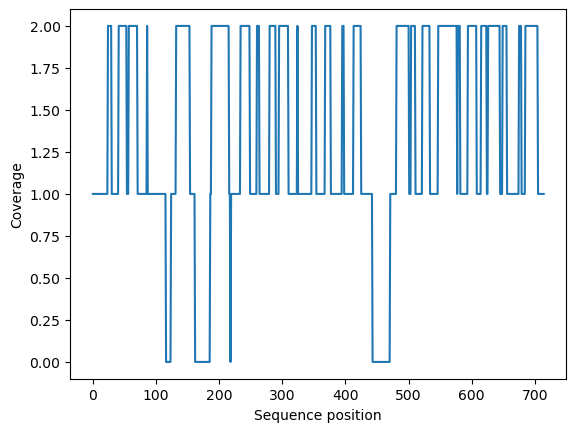

In [42]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'artificialTranscript_mCherry_t1'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['mCherry']['artificialTranscript_mCherry_t1'], seq_len)

Calculate OTs for 0/1 genes.


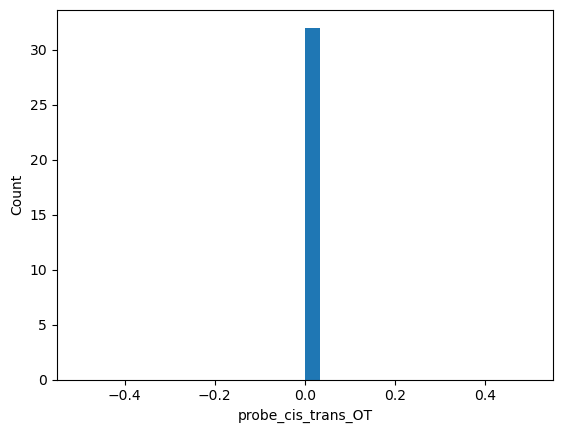

In [43]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

# Output

## Default csv output

In [44]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(probe_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry/designed_probes.csv


# IDT plate without primers

In [46]:
all_well_positions = []
for _row in list('ABCDEFGH'):
    for _col in range(1,13,1):
        all_well_positions.append(f"{_row}{_col}")

In [48]:
probe_plate_df = {
    'Well Position':[], 
    'Name':[], 
    'Sequence':[],
}

for _i, (_name, _seq) in df_all_probes[['probe_names','target_readout_sequence_rc']].iterrows():
    if 'mCherry' in _name:
        probe_plate_df['Name'].append(_name)
        probe_plate_df['Sequence'].append('/5Acryd/' + _seq[20:90])
# add well position
probe_plate_df['Well Position'] = all_well_positions[:len(probe_plate_df['Name'])]
probe_plate_df = pd.DataFrame(probe_plate_df)

In [49]:
probe_plate_df

,Well Position,Name,Sequence
0,A1,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/CATGTTATCCTCCTCGCCCTTGCTCACCATGGATGTTA...
1,A2,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/TCCATGTGCACCTTGAAGCGCATGAACTCCGGATGTTA...
2,A3,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/GCCGTTCACGGAGCCCTCCATGTGCACCTTGGATGTTA...
3,A4,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/TCGCCCTCGCCCTCGATCTCGAACTCGTGGGGATGTTA...
4,A5,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/TCAGCTTGGCGGTCTGGGTGCCCTCGTAGGGGATGTTA...
5,A6,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/GGTCACCTTCAGCTTGGCGGTCTGGGTGCCGGATGTTA...
6,A7,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/CCGTACATGAACTGAGGGGACAGGATGTCCGGATGTTA...
7,A8,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/GTCGGCGGGGTGCTTCACGTAGGCCTTGGAGGATGTTA...
8,A9,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/CAAGTAGTCGGGGATGTCGGCGGGGTGCTTGGATGTTA...
9,A10,mCherry_artificialTranscript_mCherry_t1_shift:...,/5Acryd/TTGAAGCCCTCGGGGAAGGACAGCTTCAAGGGATGTTA...


In [52]:
# save
import time
overwrite = True
save_common_probe_plate_filename = os.path.join(library_folder,
                             f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_smFISH_mCherry_IDTplate.xlsx")

if not os.path.exists(save_common_probe_plate_filename) or overwrite:
    print(f"saving probes to file: {save_common_probe_plate_filename}")
    probe_plate_df.to_excel(save_common_probe_plate_filename, index=None)

saving probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry/2023_8_21_smFISH_mCherry_IDTplate.xlsx


In [51]:
reverse_complement(df_all_probes['target_sequence'].values[-1])

'TTCATTACTTGTACAGCTCGTCCATGCCGC'